<a href="https://colab.research.google.com/github/kithmiGunawardna/Hate_Speech_detection/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tf-models-official==2.13.*
!pip install --upgrade gensim
!pip install keras-preprocessing
!pip install lime

# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=168465550466f84834cd80c6bd77fc3d22aebdd89cd29665035c234877cac179
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import shutil
import os

# Example: Clear TensorFlow cache
cache_dir = '/root/.keras'
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)


In [ ]:
#memory clearing
import gc
gc.collect()


41

In [ ]:
#import relevant libraraies
import pandas as pd
import numpy as np
from google.colab import drive
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from transformers import BertTokenizer

#imprtant libraris for visualization
import matplotlib.pyplot as plt
import seaborn as sns



from tensorflow import keras
from tensorflow.keras import layers
import re
import string
from sklearn.utils import resample
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split

import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

#word embading using pretrain model
from gensim.models import Word2Vec
from matplotlib import pyplot
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer


#LSTM model
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense


from keras.initializers import Constant
from keras.callbacks import EarlyStopping

#validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



#hide warning
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.get_logger().setLevel('ERROR')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 0 - hate speech 1 - offensive language 2 - neither

In [ ]:
#import dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Campus_Research/New_data.csv',encoding='latin1')

Mounted at /content/drive


In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
28074,28588,3,0,0,3,2,"""Engagement in policy discussions can lead to ..."
28075,28589,3,0,0,3,2,"""Political action can take place at the commun..."
28076,28590,3,0,0,3,2,"""Promoting inclusivity in politics is vital fo..."
28077,28591,3,0,0,3,2,"""Understanding global politics helps us naviga..."


**Cleaning the dataset**

In [ ]:
def custom_standardization(input_data):
    # Convert to lowercase if using an uncased BERT model
    lowercase = tf.strings.lower(input_data)

    # Replace HTML line breaks with space
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

    # Replace mentions, hashtags, and URLs with placeholders
    stripped_mentions = tf.strings.regex_replace(stripped_html, r"@\w+", "[MENTION]")
    stripped_hashtags = tf.strings.regex_replace(stripped_mentions, r"#\w+", "[HASHTAG]")
    stripped_urls = tf.strings.regex_replace(stripped_hashtags, r"http(?s://)?\S+", "[URL]")

    # Optional: Expand emoticons (you could use an emoticon library here if needed)
    # Example: stripped_emoticons = expand_emoticons(stripped_urls)

    # Remove excess whitespace
    cleaned_text = tf.strings.regex_replace(stripped_urls, r'\s+', ' ')

    return cleaned_text


In [ ]:
# Apply clean_text function
df.loc[:, 'tweet'] = df['tweet'].apply(custom_standardization)

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,"tf.Tensor(b""!!! rt [MENTION]: as a woman you s..."
1,1,3,0,3,0,1,tf.Tensor(b'!!!!! rt [MENTION]: boy dats cold....
2,2,3,0,3,0,1,tf.Tensor(b'!!!!!!! rt [MENTION] dawg!!!! rt [...
3,3,3,0,2,1,1,tf.Tensor(b'!!!!!!!!! rt [MENTION]: [MENTION] ...
4,4,6,0,6,0,1,tf.Tensor(b'!!!!!!!!!!!!! rt [MENTION]: the sh...
...,...,...,...,...,...,...,...
28074,28588,3,0,0,3,2,"tf.Tensor(b'""engagement in policy discussions ..."
28075,28589,3,0,0,3,2,"tf.Tensor(b'""political action can take place a..."
28076,28590,3,0,0,3,2,"tf.Tensor(b'""promoting inclusivity in politics..."
28077,28591,3,0,0,3,2,"tf.Tensor(b'""understanding global politics hel..."


In [ ]:
df['tweet']

,tweet
0,"tf.Tensor(b""!!! rt [MENTION]: as a woman you s..."
1,tf.Tensor(b'!!!!! rt [MENTION]: boy dats cold....
2,tf.Tensor(b'!!!!!!! rt [MENTION] dawg!!!! rt [...
3,tf.Tensor(b'!!!!!!!!! rt [MENTION]: [MENTION] ...
4,tf.Tensor(b'!!!!!!!!!!!!! rt [MENTION]: the sh...
...,...
28074,"tf.Tensor(b'""engagement in policy discussions ..."
28075,"tf.Tensor(b'""political action can take place a..."
28076,"tf.Tensor(b'""promoting inclusivity in politics..."
28077,"tf.Tensor(b'""understanding global politics hel..."


In [ ]:
df1 =df[['class', 'tweet']]
df1



,class,tweet
0,2,"tf.Tensor(b""!!! rt [MENTION]: as a woman you s..."
1,1,tf.Tensor(b'!!!!! rt [MENTION]: boy dats cold....
2,1,tf.Tensor(b'!!!!!!! rt [MENTION] dawg!!!! rt [...
3,1,tf.Tensor(b'!!!!!!!!! rt [MENTION]: [MENTION] ...
4,1,tf.Tensor(b'!!!!!!!!!!!!! rt [MENTION]: the sh...
...,...,...
28074,2,"tf.Tensor(b'""engagement in policy discussions ..."
28075,2,"tf.Tensor(b'""political action can take place a..."
28076,2,"tf.Tensor(b'""promoting inclusivity in politics..."
28077,2,"tf.Tensor(b'""understanding global politics hel..."


**Unbalanced data set**

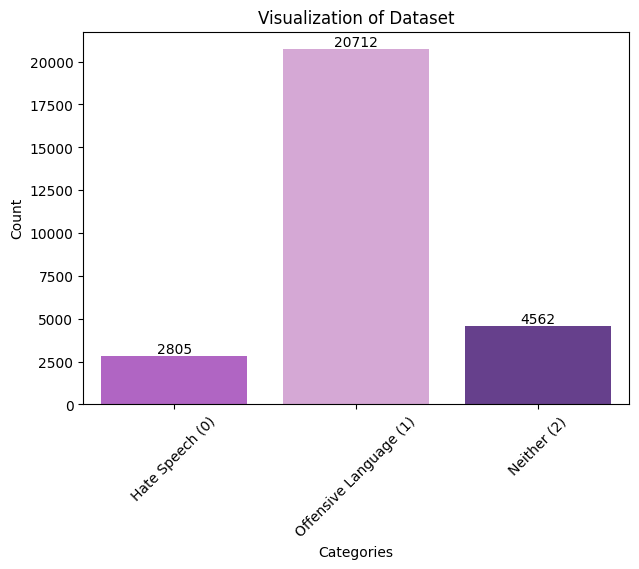

In [ ]:
# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['mediumorchid', 'plum', 'rebeccapurple']  # Purple shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')





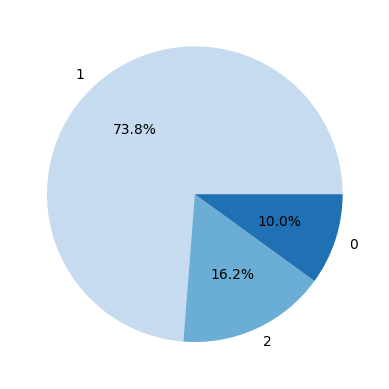

In [ ]:
blue_palette = sns.color_palette("Blues", n_colors=3)  # Customize 'n_colors' based on the number of slices

# Create a pie chart with the blue color palette
plt.pie(
    df['class'].value_counts().values,  # Values for the pie chart
    labels=df['class'].value_counts().index,  # Labels for each slice
    autopct='%1.1f%%',  # Display the percentage with one decimal place
    colors=blue_palette  # Set the color palette to shades of blue
)

# Display the pie chart
plt.show()

In [ ]:
y = df['class']
x = df.tweet

 **Balanced dataset using oversampling**

In [ ]:
#create two different dataframe of majority and minority class
df_class_1 = df1[(df1['class']==1)]
df_class_2 = df1[(df1['class']==2)]
df_class_0 = df1[(df1['class']==0)]
# undersample class_1 class
df_class_2_oversampled = resample(df_class_2,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# undersample class_1 class
df_class_0_oversampled = resample(df_class_0,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
oversampled_df  = pd.concat([df_class_2_oversampled, df_class_0_oversampled,df_class_1])

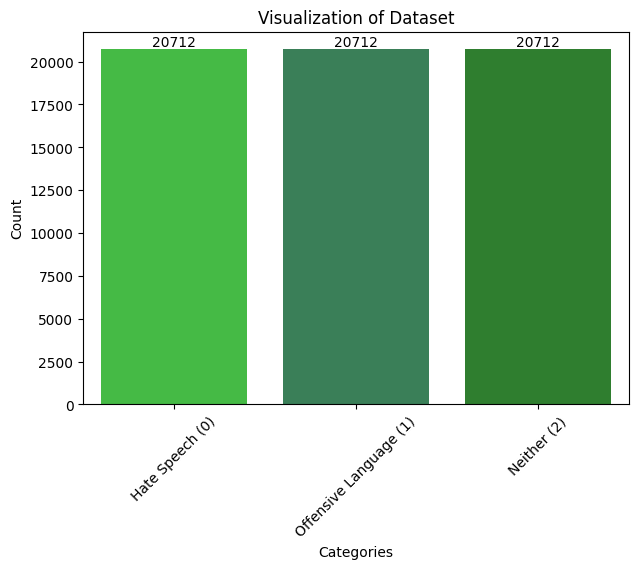

In [ ]:

# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = oversampled_df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['limegreen', 'seagreen', 'forestgreen']  # green shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')

In [ ]:
oversampled_df

,class,tweet
5077,2,"tf.Tensor(b""[MENTION] don't you have a trash c..."
22175,2,"tf.Tensor(b'three little birds', shape=(), dty..."
18224,2,"tf.Tensor(b'rt [MENTION]: rt [MENTION]: ""i\'ve..."
2870,2,"tf.Tensor(b""[MENTION] his defense is trash, an..."
27943,2,"tf.Tensor(b'""this project turned out beautiful..."
...,...,...
27674,1,"tf.Tensor(b'""his commitment to making bad deci..."
27675,1,"tf.Tensor(b'""she has an unmatched ability to i..."
27676,1,"tf.Tensor(b'""you\xc2\x92re quite skilled at co..."
27677,1,"tf.Tensor(b'""it\xc2\x92s impressive how often ..."


In [ ]:
oversampled_df1 = oversampled_df.copy()


In [ ]:
oversampled_df.to_csv('/content/drive/My Drive/df.csv', index=False)

In [ ]:
oversampled_df1['tweet'] = oversampled_df['tweet'].astype(str)

# Now you can calculate unique values
unique_values = oversampled_df1['tweet'].nunique()
print(unique_values)


27362


**BERT tokenizer and generate the necessary inputs**

In [ ]:
# # Load the pre-trained BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Sample data
# texts = oversampled_df1['tweet'].tolist()  # Assuming the cleaned text data is in this column

# # Tokenization with padding and truncation
# # This will return inputs suitable for BERT, including input_ids and attention_mask
# encoding = tokenizer(
#     texts,
#     padding=True,            # Pad sequences to the maximum sequence length in the batch
#     truncation=True,         # Truncate sequences longer than the model's max length
#     max_length=128,          # You can adjust this length based on your model/input size
#     return_tensors="tf"      # Return as TensorFlow tensors
# )

# # Access input IDs and attention masks from the encoding
# input_ids = encoding['input_ids']
# attention_masks = encoding['attention_mask']

# print("Input IDs:", input_ids)
# print("Attention Masks:", attention_masks)

# #this part is not nedded


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')


**data spliting**

In [ ]:
X = oversampled_df['tweet']  # Input text data
y = oversampled_df['class']   # Labels

# First, split into training and temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Now split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
oversampled_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 62136 entries, 5077 to 27678
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   62136 non-null  int64 
 1   tweet   62136 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:

# Assuming 'oversampled_df' is your DataFrame
X = oversampled_df['tweet'].astype(str)  # Ensure all tweets are strings
y = oversampled_df['class'].astype(int)   # Ensure labels are integers

# First, split into training and temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Now split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Function to create a tf.data.Dataset from the split data
def create_tf_dataset(X, y, batch_size=32):
    # Convert to NumPy arrays to avoid conversion issues
    X = X.values.astype(str)  # Ensure X is a NumPy array of strings
    y = y.values.astype(int)   # Ensure y is a NumPy array of integers

    # Create a TensorFlow dataset from the input data and labels
    tf_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    # Shuffle, batch, and prefetch the dataset
    return tf_dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create TensorFlow datasets for training, validation, and testing
train_ds = create_tf_dataset(X_train, y_train)
val_ds = create_tf_dataset(X_val, y_val)
test_ds = create_tf_dataset(X_test, y_test)

# Optional: Print the shapes of the datasets to verify
print("Training dataset shape:", train_ds.element_spec)
print("Validation dataset shape:", val_ds.element_spec)
print("Testing dataset shape:", test_ds.element_spec)



Training dataset shape: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Validation dataset shape: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Testing dataset shape: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


**Choosing the Bert Model**

In [ ]:
# Define model name mappings
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    # Add other model definitions as needed
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    # Add other preprocessing definitions as needed
}

# Selecting a smaller BERT model variant to reduce memory usage
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

# Setting the model URLs
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')




BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


**The preprocessing model**

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
# Assume you have sentences in `oversampled_df1['tweet']` and that `text_inputs` should be in raw text format
text_inputs = tf.constant(X_train.values) # `text_inputs` is in raw text

# Now apply the preprocessing model on the text
processed_inputs = bert_preprocess_model(text_inputs)  # This generates BERT-ready inputs


**Using the BERT model**

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(processed_inputs)

**model training**

In [ ]:
# def build_classifier_model():
#     # Clear any previous session to free up memory
#     tf.keras.backend.clear_session()

#     # Input layer for text
#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

#     # Preprocessing layer for BERT
#     preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
#     encoder_inputs = preprocessing_layer(text_input)

#     # Encoder layer with trainable=False to reduce memory use
#     encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
#     outputs = encoder(encoder_inputs)

#     # Using a single pooling layer to reduce output dimensions
#     net = outputs['pooled_output']

#     # Dropout and Dense layers for classification
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)

#     return tf.keras.Model(text_input, net)



def build_classifier_model():
    # Clear any previous session to free up memory
    tf.keras.backend.clear_session()

    # Input layer for text
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing layer for BERT
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # Encoder layer with partial trainability
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    # Additional Dense and Dropout Layers
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Dropout(0.3)(net)

    # Final output layer with softmax activation
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)

    return tf.keras.Model(text_input, net)


In [ ]:
classifier_model = build_classifier_model()

**loss Function**

In [ ]:
# Use categorical cross-entropy for multiclass classification
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Use categorical accuracy for multiclass classification
metrics = tf.metrics.SparseCategoricalAccuracy()


In [ ]:
epochs = 50
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on what you want to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[early_stopping])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/50
1360/1360 [==============================] - 217s 157ms/step - loss: 1.5840 - sparse_categorical_accuracy: 0.3614 - val_loss: 1.0045 - val_sparse_categorical_accuracy: 0.4756
Epoch 2/50
1360/1360 [==============================] - 211s 155ms/step - loss: 1.2058 - sparse_categorical_accuracy: 0.5044 - val_loss: 0.6599 - val_sparse_categorical_accuracy: 0.7383
Epoch 3/50
1360/1360 [==============================] - 209s 154ms/step - loss: 0.7905 - sparse_categorical_accuracy: 0.7060 - val_loss: 0.4557 - val_sparse_categorical_accuracy: 0.8369
Epoch 4/50
1360/1360 [==============================] - 214s 158ms/step - loss: 0.5634 - sparse_categorical_accuracy: 0.8054 - val_loss: 0.3590 - val_sparse_categorical_accuracy: 0.8697
Epoch 5/50
1360/1360 [==============================] - 211s 155ms/step - loss: 0.4402 - sparse_categorical_accuracy: 0.8470 - val_loss: 0.3190 - val_sparse_categor

**Validation**

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:

# Extracting the history for plotting
history_dict = history.history
print(history_dict.keys())

# Get accuracy and loss values
acc = history_dict['sparse_categorical_accuracy']  # Adjusted for sparse categorical
val_acc = history_dict['val_sparse_categorical_accuracy']  # Adjusted for validation
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Number of epochs
epochs = range(1, len(acc) + 1)

# Plotting
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')  # Training loss
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Validation loss
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')  # Training accuracy
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')  # Validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Show the plots
plt.show()
